In [1]:
%pylab inline
from constant import * 

Populating the interactive namespace from numpy and matplotlib


In [2]:
Vgrid = np.load("Value00.npy")

In [3]:
num = 10000
# calculate the stationary distribution 
S_distribution = jnp.ones(nS)/nS
for _ in range(100):
    S_distribution = jnp.matmul(S_distribution, Ps)
    
#P(0,1)
P01 = jnp.dot(Pe[:,0],S_distribution)
#P(1,0)
P10 = jnp.dot(Pe[:,1],S_distribution)
jnp.array([[1-P01, P01],[P10, 1-P10]])

E_distribution = jnp.ones(2)/2
for _ in range(100):
    E_distribution = jnp.matmul(E_distribution, jnp.array([[1-P01, P01],[P10, 1-P10]]))
'''
    x = [w,n,m,s,e,o]
    x = [5,0,0,0,0,0]
'''

from jax import random

def simulation(key):
    initE = random.choice(a = nE, p=E_distribution, key = key)
    initS = random.choice(a = nS, p=S_distribution, key = key)
    x = [5, 0, 0, initS, initE, 0]
    path = []
    move = []
    for t in range(T_min, T_max):
        _, key = random.split(key)
        if t == T_max-1:
            _,a = V(t,Vgrid[:,:,:,:,:,:,t],x)
        else:
            _,a = V(t,Vgrid[:,:,:,:,:,:,t+1],x)
        xp = transition(t,a.reshape((1,-1)),x)
        p = xp[:,-1]
        x_next = xp[:,:-1]
        path.append(x)
        move.append(a)
        x = x_next[random.choice(a = nS*nE, p=p, key = key)]
    path.append(x)
    return jnp.array(path), jnp.array(move)

In [4]:
%%time
# simulation part 
keys = vmap(random.PRNGKey)(jnp.arange(num))
Paths, Moves = vmap(simulation)(keys)

CPU times: user 4h 33min 34s, sys: 27min 25s, total: 5h 1min
Wall time: 14min 16s


In [5]:
# x = [w,n,m,s,e,o]
# x = [0,1,2,3,4,5]
ws = Paths[:,:,0].T
ns = Paths[:,:,1].T
ms = Paths[:,:,2].T
ss = Paths[:,:,3].T
es = Paths[:,:,4].T
os = Paths[:,:,5].T
cs = Moves[:,:,0].T
bs = Moves[:,:,1].T
ks = Moves[:,:,2].T
hs = Moves[:,:,3].T
actions = Moves[:,:,4].T

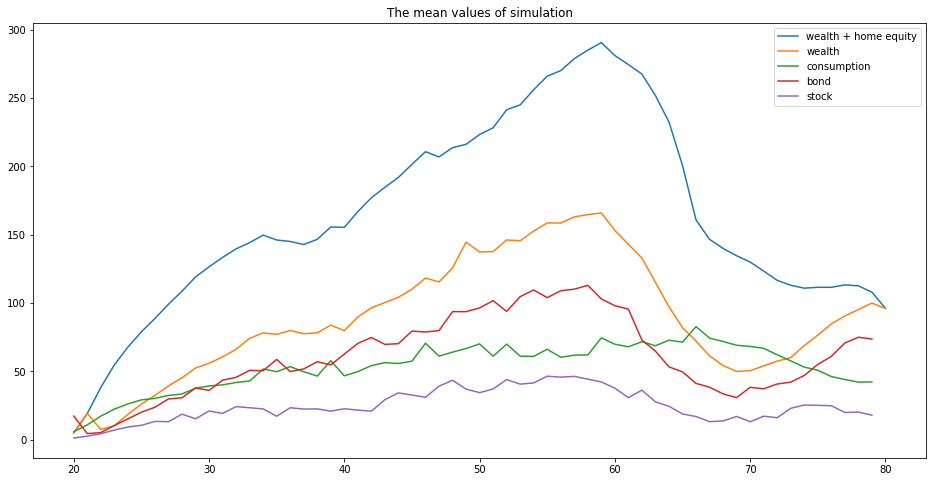

In [6]:
plt.figure(figsize = [16,8])
plt.title("The mean values of simulation")
plt.plot(range(20, T_max + 21),jnp.mean(ws + H*pt*os - ms,axis = 1), label = "wealth + home equity")
plt.plot(range(20, T_max + 21),jnp.mean(ws,axis = 1), label = "wealth")
plt.plot(range(20, T_max + 20),jnp.mean(cs,axis = 1), label = "consumption")
plt.plot(range(20, T_max + 20),jnp.mean(bs,axis = 1), label = "bond")
plt.plot(range(20, T_max + 20),jnp.mean(ks,axis = 1), label = "stock")
plt.legend()

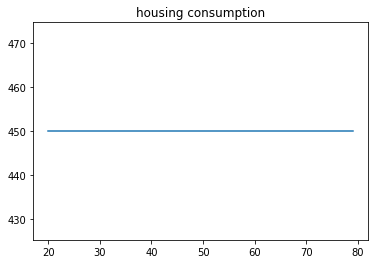

In [7]:
plt.title("housing consumption")
plt.plot(range(20, T_max + 20),(hs).mean(axis = 1), label = "housing")

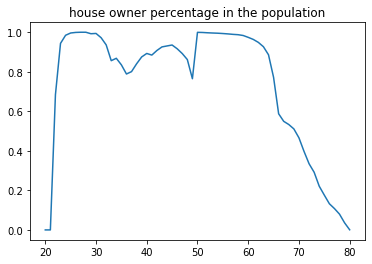

In [8]:
plt.title("house owner percentage in the population")
plt.plot(range(20, T_max + 21),(os).mean(axis = 1), label = "owning")

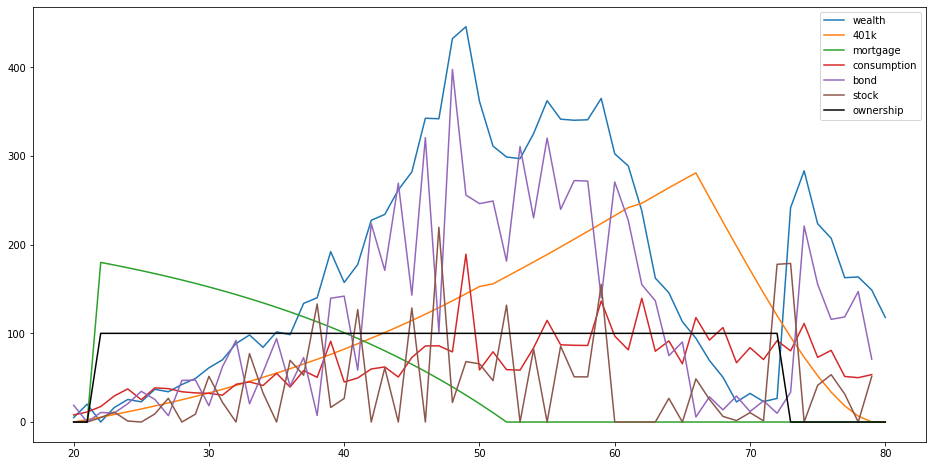

In [253]:
# agent number, x = [w,n,m,s,e,o]
agentNum = 5033
plt.figure(figsize = [16,8])
plt.plot(range(20, T_max + 21),ws[:,agentNum], label = "wealth")
plt.plot(range(20, T_max + 21),ns[:,agentNum], label = "401k")
plt.plot(range(20, T_max + 21),ms[:,agentNum], label = "mortgage")
plt.plot(range(20, T_max + 20),cs[:,agentNum], label = "consumption")
plt.plot(range(20, T_max + 20),bs[:,agentNum], label = "bond")
plt.plot(range(20, T_max + 20),ks[:,agentNum], label = "stock")
plt.plot(range(20, T_max + 21),os[:,agentNum]*100, label = "ownership", color = "k")
plt.legend()

In [250]:
(ws + H*pt*os - ms)[29,:].max()

DeviceArray(640.4464, dtype=float32)

In [252]:
jnp.where((ws + H*pt*os - ms)[29,:] == (ws + H*pt*os - ms)[29,:].max())

(DeviceArray([5033], dtype=int32),)

In [224]:
# agent selling time collection
agentTime = []
for t in range(30):
    if ((os[t,:] == 1) & (os[t+1,:] == 0)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 1) & (os[t+1,:] == 0))[0]:
            agentTime.append([t, agentNum])
agentTime = jnp.array(agentTime)

In [225]:
agentTime = agentTime[agentTime[:,0] == 28]
agentTime

DeviceArray([[  28,    0],
             [  28,   20],
             [  28,   30],
             ...,
             [  28, 9990],
             [  28, 9997],
             [  28, 9999]], dtype=int32)

In [226]:
# agent at the same time time collection
agentTimeKeep = []
for t in set(jnp.array(agentTime[:,0], dtype = int8)):
    if ((os[t,:] == 1) & (os[t+1,:] == 1)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 1) & (os[t+1,:] == 1))[0]:
            agentTimeKeep.append([t, agentNum])
agentTimeKeep = jnp.array(agentTimeKeep)

In [227]:
def percentChange(agentTime):
    wealthBeforeSell = ws[agentTime[:,0] - 1, agentTime[:,1]] 
    wealthAtSell = ws[agentTime[:,0], agentTime[:,1]]
    return (wealthAtSell - wealthBeforeSell)/wealthBeforeSell

In [228]:
percentChange(agentTime).mean()

DeviceArray(1.6963924, dtype=float32)

In [229]:
percentChange(agentTimeKeep).mean()

DeviceArray(0.5010255, dtype=float32)

In [232]:
es[agentTime[:,0], agentTime[:,1]].mean()

DeviceArray(0.83355796, dtype=float32)

In [233]:
es[agentTimeKeep[:,0], agentTimeKeep[:,1]].mean()

DeviceArray(0.9390073, dtype=float32)

In [120]:
percentChange(agentTime).mean()

DeviceArray(-1.8163296, dtype=float32)

In [129]:
percentChange(agentTime).std()

DeviceArray(33.687775, dtype=float32)

In [121]:
percentChange(agentTimeKeep).mean()

DeviceArray(-0.6936017, dtype=float32)

In [128]:
percentChange(agentTimeKeep).std()

DeviceArray(29.469044, dtype=float32)

In [138]:
from scipy import stats
## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(percentChange(agentTime),percentChange(agentTimeKeep))
print("t = " + str(t2))
print("p = " + str(p2))

t = -2.891140935307616
p = 0.0038391621997037324


(array([ 677., 1076.,  735., 1217.,  761.,  411.,  811.,  488.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ],
       dtype=float32),
 <a list of 8 Patch objects>)

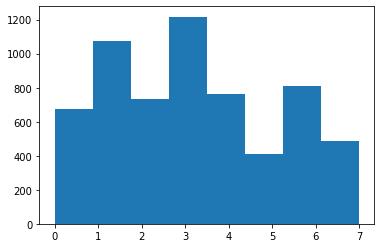

In [126]:
plt.hist(ss[agentTime[:,0], agentTime[:,1]],bins = 8)

(array([ 9660., 13642., 12344., 19498., 19511., 12895., 13988.,  9857.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ],
       dtype=float32),
 <a list of 8 Patch objects>)

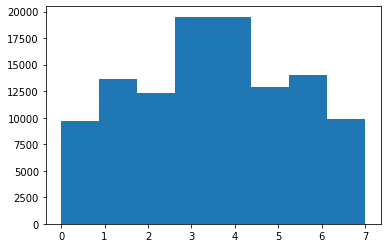

In [127]:
plt.hist(ss[agentTimeKeep[:,0], agentTimeKeep[:,1]],bins = 8)